<a href="https://colab.research.google.com/github/efti-nile/solafune/blob/main/Solafune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install -q imagecodecs

# Imports

In [56]:
from pathlib import Path
import os
import shutil
import json

from pprint import pprint
import numpy as np
from scipy import stats
import tifffile
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Load Data

In [29]:
%cd /content

data_root = "/content/drive/MyDrive/Solafune"

# Test
![ ! -f test_images.zip ] && cp $data_root/test_images.zip .
![ ! -d test ] && unzip -q test_images.zip -d test

# Train
![ ! -f train_images.zip ] && cp $data_root/train_images.zip .
![ ! -d train ] && unzip -q train_images.zip -d train
!cp $data_root/train_annotation.json train

# Sample
!cp $data_root/sample.json .

/content


# Explore Single Image

In [30]:
img = tifffile.imread('train/images/train_0.tif')
type(img), img.dtype, img.shape, img.nbytes // 2**20

(numpy.ndarray, dtype('float64'), (804, 981, 12), 72)

In [31]:
for i in range(img.shape[2]):
    print(f"Channel {i}")
    print(stats.describe(img[:, :, i].flatten()))

Channel 0
DescribeResult(nobs=788724, minmax=(220.5, 1793.5), mean=477.0197574922703, variance=12887.837943714669, skewness=1.3753871173595769, kurtosis=6.750886438398968)
Channel 1
DescribeResult(nobs=788724, minmax=(133.5, 5266.0), mean=574.1639349571194, variance=38897.91685733301, skewness=3.136572992141515, kurtosis=24.158414737941385)
Channel 2
DescribeResult(nobs=788724, minmax=(176.0, 5774.0), mean=876.9985663685243, variance=50507.0495699115, skewness=2.9558250464916918, kurtosis=21.383018741290147)
Channel 3
DescribeResult(nobs=788724, minmax=(170.0, 5944.0), mean=1008.042801760557, variance=123814.54604604264, skewness=1.492501012737036, kurtosis=5.7870980128160845)
Channel 4
DescribeResult(nobs=788724, minmax=(182.5, 5036.0), mean=1518.4334695947114, variance=75880.01300353066, skewness=1.2958632628273348, kurtosis=7.202203197314082)
Channel 5
DescribeResult(nobs=788724, minmax=(85.5, 5088.5), mean=2500.5449341660183, variance=154519.85625722265, skewness=1.2177123591983794

In [32]:
anns = json.load(open('train/train_annotation.json'))

In [33]:
def get_segs(anns, file_name):
    for objs in anns['images']:
        if objs['file_name'] == file_name:
            segs = [obj['segmentation'] for obj in objs['annotations']]
            return segs

In [38]:
def convert_to_tuples(coordinates):
  """
  Converts a flat list of coordinates to a list of tuples.

  Args:
    coordinates: A list of coordinates in the format [x1, y1, x2, y2, ...].

  Returns:
    A list of tuples representing the coordinates [(x1, y1), (x2, y2), ...].
  """
  return [(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)]

In [37]:
segs = get_segs(anns, 'train_0.tif')
len(segs)

671

In [66]:
import matplotlib.patches as patches

def plot_channels_with_polygons(image, polygons, max_columns=3):
    """
    Plots all channels of a numpy ndarray as greyscale images and draws polygons on them.

    Args:
        image: A numpy ndarray of shape (width, height, channels).
        polygons: A list of polygons, where each polygon is a list of (x, y) tuples.
        max_columns: Maximum number of channels to plot in a row.
    """
    num_channels = image.shape[2]
    num_rows = (num_channels + max_columns - 1) // max_columns

    fig, axes = plt.subplots(num_rows, max_columns, figsize=(4 * max_columns, 4 * num_rows))

    for i in range(num_channels):
        row = i // max_columns
        col = i % max_columns
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image[:, :, i], cmap='gray')

        # Draw polygons with different colors
        for j, polygon in enumerate(polygons):
            patch = patches.Polygon(polygon, closed=True, fill='r',
                                    edgecolor='r', linewidth=1, alpha=0.6)
            ax.add_patch(patch)

        ax.set_title(f"Channel {i}")
        ax.axis('off')

    # Remove any unused subplots
    for i in range(num_channels, num_rows * max_columns):
        row = i // max_columns
        col = i % max_columns
        ax = axes[row, col] if num_rows > 1 else axes[col]
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

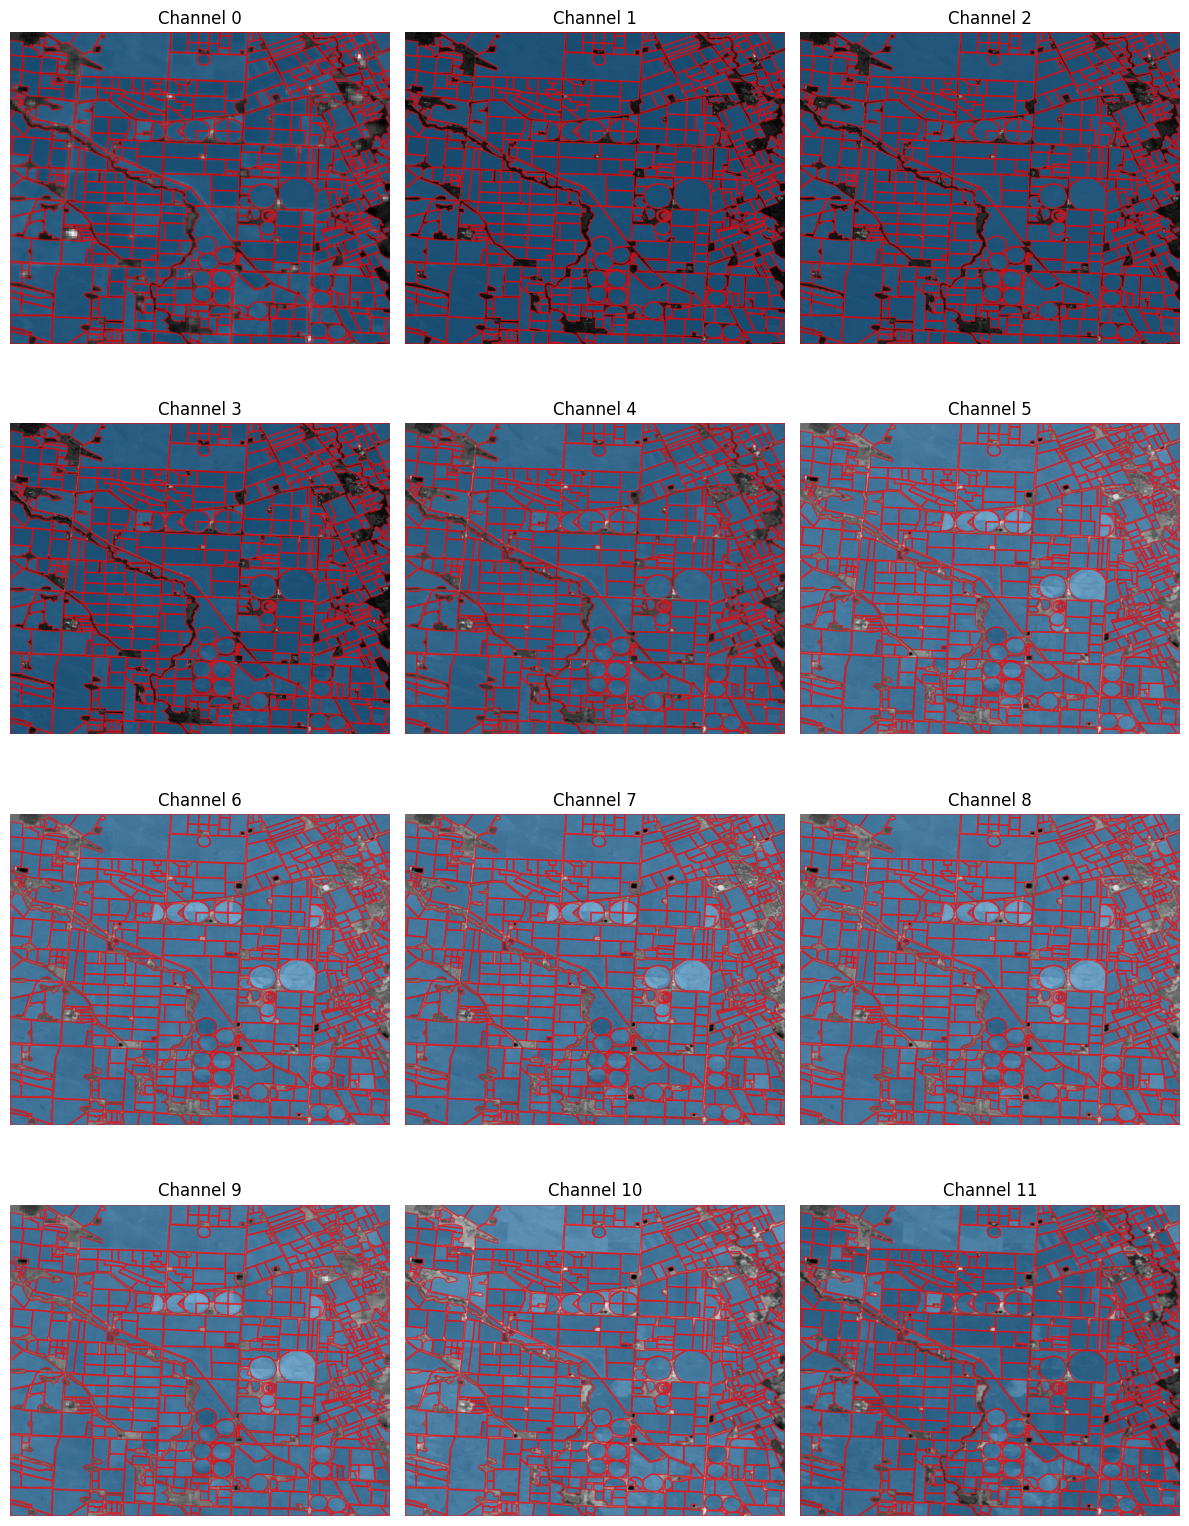

In [67]:
polys = [convert_to_tuples(seg) for seg in segs]
plot_channels_with_polygons(img, polys)